In [1]:
import numpy as np
import matplotlib.pyplot as plt
import harmonic as hm
import scipy

# Bayes Model comparison
Model 1: Fair coin $(p = 0.5)$ <br>
Model 2: Rigged to heads $(p = 0.9)$ <br>
Model 3: Rigged to tails $(p = 0.1)$ <br>

In [ ]:
#Define the models and their prior probabilities
models = ['Fair', 'Heads_Rigged', 'Tails_Rigged']
models_p = [0.5, 0.9, 0.1]

# Equal prior probability for each model
priors = np.array([1/3, 1/3, 1/3])  

In [4]:
# Let's say we observed the following sequence of coin flips: 
data = ['H', 'H', 'T', 'T', 'H', 'H', 'H', 'H', 'H', 'H']
data_binary = [1 if x == 'H' else 0 for x in data]
n_heads = data.count('H')
n_tails = len(data) - n_heads

## Bayes Updating
To calculate which model is more likely given the data, we can use the Bayes rule to update our prior to give us the posterior belive of our models. <br>
The posterior probability of a model given the data is given by:
$$ \begin{align*}
P(\mathcal{M}_i|\text{data}) &= \frac{P(\text{data}|\mathcal{M}_i)P(\mathcal{M}_i)}{\sum_{j=1}^{3} P(\text{data}|\mathcal{M}_j)P(\mathcal{M}_j)} = \frac{P(\text{data}|\mathcal{M}_i)P(\mathcal{M}_i)}{P(\text{data})} \\ \\
\text{Posterior} &= \frac{\text{Likelihood} \times \text{Prior}}{\text{Evidence}}
\end{align*} $$

## Prior
The prior probability of a model is our initial belief of the model before observing the data. <br>
In our case, we assume that all models are equally likely, so $P(\mathcal{M}_i) = \frac{1}{3}$.

## Likelihood
The likelihood function gives us the probability of observing the data given the model $\mathcal{M}_i$ is true. <br>

In [ ]:
# Compute the likelihood of the data under each model
likelihoods = np.ones(3)

for obs in data_binary:
    for model_id,_ in enumerate(models):
        likelihoods[model_id] *= models_p[model_id]*obs + (1 - models_p[model_id])*(1-obs)

print(likelihoods)

[9.7656250e-04 4.3046721e-03 8.1000000e-09]


## Evidence
The evidence is the probability of observing the data regardless of the model. <br>
$$ P(\text{data}) = \sum_{j=1}^{3} P(\text{data}|\mathcal{M}_j)P(\mathcal{M}_j) $$

In [24]:
evidence = np.sum(likelihoods * priors)
print(evidence)

0.001760414233333333


## Model Comparison


In [44]:
model_posteriors = likelihoods * priors / evidence

print("Model posteriors:"+
      f"\nGiven the observations {data}" + 
      f"\nThe probabilities of the three models describing our data are:")
for m,p in zip(models, model_posteriors):
    print(f"{m:{""}{12}}: {p*100:.1f} %")

Model posteriors:
Given the observations ['H', 'H', 'T', 'T', 'H', 'H', 'H', 'H', 'H', 'H']
The probabilities of the three models describing our data are:
Fair        : 18.5 %
Heads_Rigged: 81.5 %
Tails_Rigged: 0.0 %


## Plot

In [ ]:
def update_posterior(prior, obs):
    # Compute the new model posteriors given a single new observation (obs)
    likelihoods = np.ones(3)
    for model_id,_ in enumerate(models):
        likelihoods[model_id] = models_p[model_id]*obs + (1 - models_p[model_id])*(1-obs)

    evidence = np.sum(likelihoods * prior)
    model_posteriors = likelihoods * prior / evidence
    return model_posteriors

In [ ]:
# Initial model prior probabilities
priors = np.array([1/3, 1/3, 1/3])
posterior_probs = {model: [p] for p, model in zip(priors, models)}

for i, toss in enumerate(data_binary):
    priors = update_posterior(priors, toss)

    # Store the updated posterior probabilities
    for model, posterior in zip(models, priors):
        posterior_probs[model].append(posterior)

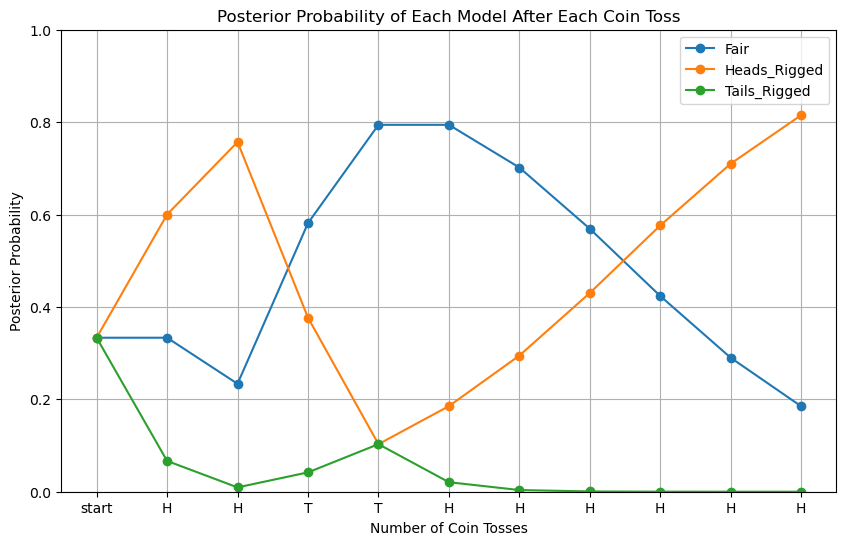

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 6))
for model in models:
    plt.plot(range(0, len(data) + 1), posterior_probs[model], marker='o', label=model)

plt.xlabel('Number of Coin Tosses')
plt.ylabel('Posterior Probability')
plt.title('Posterior Probability of Each Model After Each Coin Toss')
plt.legend()
plt.xticks(range(0, len(data) + 1), ["start"]+data)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Learned Harmonic Mean Estimator
The learned harmonic mean estimator is a method to estimate the evidence in the case its computation is intractable with the use of importance sampling. <br> 

We utilize the fact that the harmonic mean of the likelihoods is the reciprocal of the evidence. <br>
The harmonic mean estimator is given by:

$$ \begin{align*}
\rho &= \mathbb{E}_ {P(\theta|x)} [\frac1{\mathcal{L}(\theta)}] \\
 &= \int d\theta \frac1{\mathcal{L}(\theta)}P(\theta|x) \\
 &= \int d\theta \frac1{\mathcal{L}(\theta)}\frac{\mathcal{L}(\theta) \pi(\theta)}{z} \\
 &= \frac1z \\
=> \hat\rho &=\frac1N \sum_{i=1}^{N} \frac1{\mathcal{L}(\theta)}
\end{align*} $$

If we treat this as an importance sampling problem, we can elimate the problem of an exploding variance. <br>
Therefore we introduce a new target distribution $\phi(\theta)$. <br>
The harmonic mean estimator can then be re-written as:
$$
z^{-1} = \frac1N \sum_{i=1}^{N} \frac{\phi(\theta_i)}{\mathcal{L}(\theta_i)\pi(\theta_i)}, \quad \text{where } \theta_i \sim p(\theta|\text{data})
$$

Where we sample from the posterior distribution and calculate the likelihood of the sample.<br>
The ideal target distribution $\phi(\theta)$ is the posterior distribution $p(\theta|\text{data})$ which we can learn using SBI.